<a href="https://colab.research.google.com/github/saicharan-r/Erav1/blob/main/S7/S7-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%cd /content/Erav1/S7

/content/Erav1/S7


In [24]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from models import Model_2 as Net

In [25]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [26]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [27]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


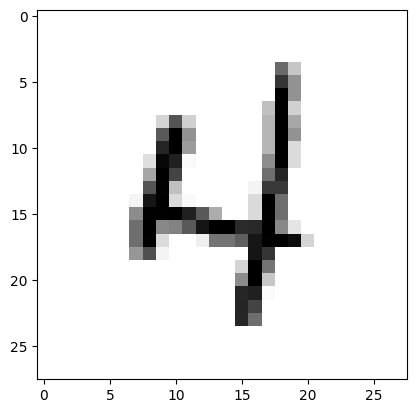

In [28]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


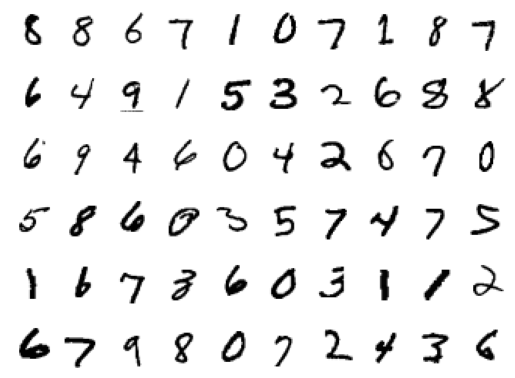

In [29]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [30]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           1,440
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             160
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           1,440

In [31]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [32]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.29873010516166687 Batch_id=468 Accuracy=37.68: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]



Test set: Average loss: 0.4746, Accuracy: 8440/10000 (84.40%)

EPOCH: 1


Loss=0.2875621020793915 Batch_id=468 Accuracy=89.56: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.2307, Accuracy: 9285/10000 (92.85%)

EPOCH: 2


Loss=0.11265061050653458 Batch_id=468 Accuracy=93.89: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.1186, Accuracy: 9626/10000 (96.26%)

EPOCH: 3


Loss=0.18066997826099396 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0774, Accuracy: 9759/10000 (97.59%)

EPOCH: 4


Loss=0.0724017322063446 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]



Test set: Average loss: 0.0772, Accuracy: 9761/10000 (97.61%)

EPOCH: 5


Loss=0.02113899402320385 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]



Test set: Average loss: 0.0527, Accuracy: 9838/10000 (98.38%)

EPOCH: 6


Loss=0.04564202204346657 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]



Test set: Average loss: 0.0544, Accuracy: 9825/10000 (98.25%)

EPOCH: 7


Loss=0.10976690798997879 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0741, Accuracy: 9774/10000 (97.74%)

EPOCH: 8


Loss=0.050663020461797714 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:17<00:00, 27.28it/s]



Test set: Average loss: 0.0486, Accuracy: 9844/10000 (98.44%)

EPOCH: 9


Loss=0.008859063498675823 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]



Test set: Average loss: 0.0518, Accuracy: 9829/10000 (98.29%)

EPOCH: 10


Loss=0.012695313431322575 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:17<00:00, 26.42it/s]



Test set: Average loss: 0.0425, Accuracy: 9862/10000 (98.62%)

EPOCH: 11


Loss=0.05408887937664986 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0416, Accuracy: 9860/10000 (98.60%)

EPOCH: 12


Loss=0.041742563247680664 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.58it/s]



Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

EPOCH: 13


Loss=0.006509040016680956 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0378, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Loss=0.03893275931477547 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0512, Accuracy: 9841/10000 (98.41%)

EPOCH: 15


Loss=0.02862546592950821 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0406, Accuracy: 9863/10000 (98.63%)

EPOCH: 16


Loss=0.0049800509586930275 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0419, Accuracy: 9872/10000 (98.72%)

EPOCH: 17


Loss=0.05203469097614288 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:17<00:00, 26.77it/s]



Test set: Average loss: 0.0381, Accuracy: 9877/10000 (98.77%)

EPOCH: 18


Loss=0.06663507223129272 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.06it/s]



Test set: Average loss: 0.0438, Accuracy: 9861/10000 (98.61%)

EPOCH: 19


Loss=0.06577111780643463 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0380, Accuracy: 9884/10000 (98.84%)



Text(0.5, 1.0, 'Test Accuracy')

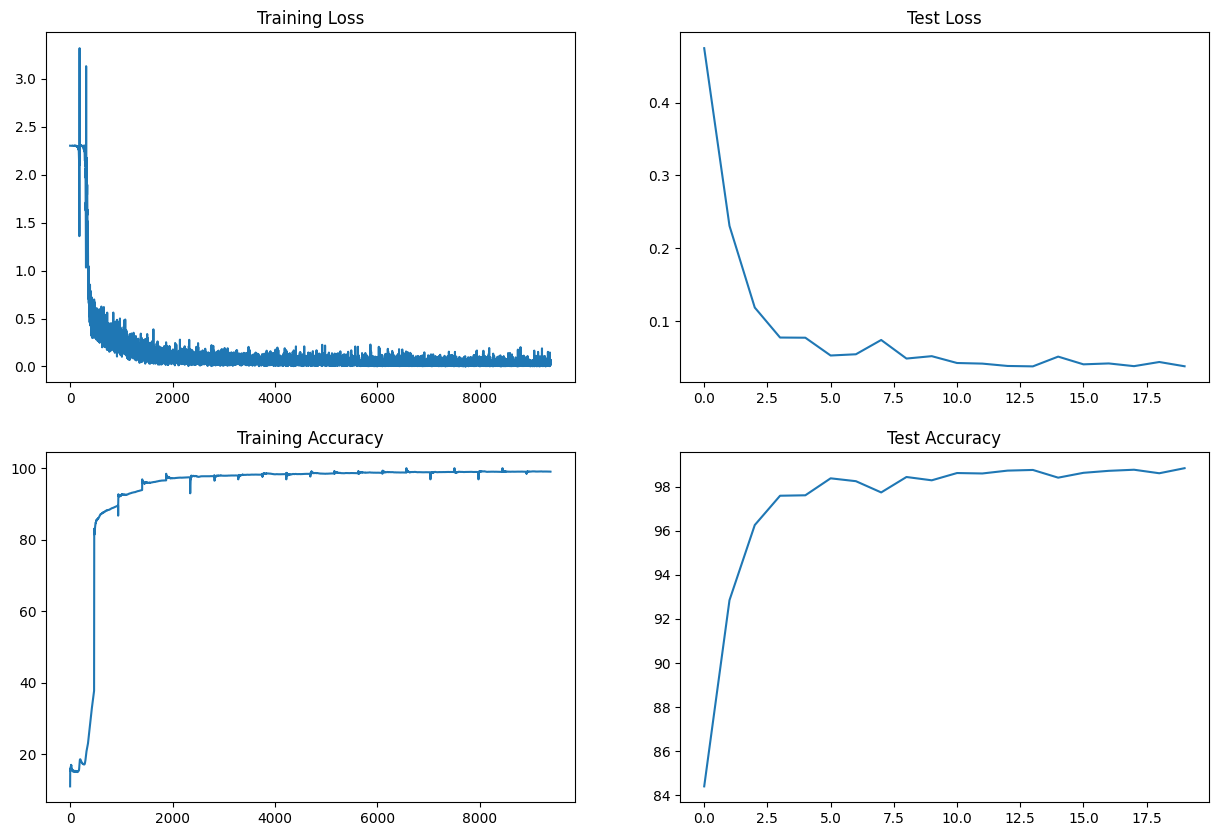

In [33]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")